In [1]:
import torch.nn as nn
import torch
import os
from torchvision import transforms, datasets
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm
import torchvision.transforms as tt
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import torch.nn.functional as F

In [2]:
def get_default_device():
    #Pick GPU if available, else CPU
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    #Move tensor(s) to chosen device
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    #Wrap a dataloader to move data to a device
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        #Yield a batch of data after moving it to device
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [3]:
device = get_default_device()
device

device(type='cuda')

In [4]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        images, labels = images.to(device), labels.to(device)
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        images, labels = images.to(device), labels.to(device)
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [5]:
class VGG11(ImageClassificationBase):
    def __init__(self, in_channels, num_classes=29):
        super(VGG11, self).__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        
        # convolutional layers 
        self.conv_layers = nn.Sequential(
            nn.Conv2d(self.in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # fully connected linear layers
        self.linear_layers = nn.Sequential(
            nn.Linear(in_features=512*7*7, out_features=4096),
            nn.ReLU(),
            nn.Dropout2d(0.5),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),
            nn.Dropout2d(0.5),
            nn.Linear(in_features=4096, out_features=self.num_classes)
        )
    def forward(self, x):
        x = self.conv_layers(x)
        # flatten to prepare for the fully connected layers
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [6]:
transforms = tt.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

data_dir = 'D:\zzStudies\CSE499\ASL\Datasets\Dataset 1 - Image - Keggle'
image_dataset = datasets.ImageFolder(data_dir+ "/asl_alphabet_train/asl_alphabet_train", transforms)

print(image_dataset.classes)
print(len(image_dataset))

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']
87000


In [7]:
val_size = 13000
test_size = 13000
train_size = len(image_dataset) - val_size - test_size

batch_size = 32

train_ds, val_ds, test_ds = random_split(image_dataset, [train_size, val_size, test_size])
print(len(train_ds), len(val_ds), len(test_ds))

61000 13000 13000


In [8]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, shuffle=True, num_workers=4, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size*2, shuffle=True, num_workers=4, pin_memory=True)

In [9]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [10]:
@torch.no_grad()
def evaluate(model, val_dl):
    model.eval()
    outputs = [model.validation_step(batch) for batch in tqdm(val_dl)]
    return model.validation_epoch_end(outputs)

def fit(epochs, model, train_dl, val_dl, opt_func):
    history = []

    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in tqdm(train_dl):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_dl)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [11]:
model = VGG11(in_channels=3, num_classes=29).to(device)

In [12]:
# the loss function
criterion = nn.CrossEntropyLoss()

# the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, 
                      weight_decay=0.0005)
# epochs
epochs = 1

In [13]:
history = fit(epochs, model, train_dl, val_dl, optimizer)

100%|████████████████████████████████████████████████████████████████████████████████| 204/204 [00:42<00:00,  4.78it/s]

Epoch [0], val_loss: 3.3688, val_acc: 0.0339


In [14]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [15]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

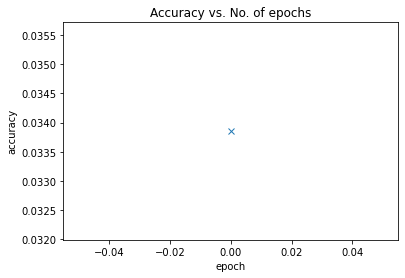

In [16]:
plot_accuracies(history)

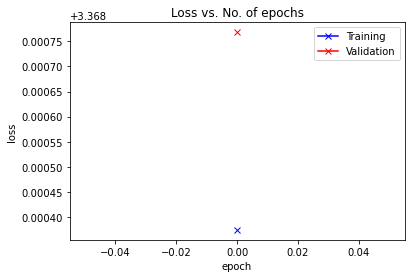

In [17]:
plot_losses(history)

In [18]:
torch.save(model.state_dict(), 'vgg11.pth')

In [19]:
evaluate(model, test_dl)

100%|████████████████████████████████████████████████████████████████████████████████| 204/204 [00:42<00:00,  4.81it/s]


{'val_loss': 3.369105339050293, 'val_acc': 0.03454350307583809}